In [ ]:
import os
import time
import copy
import glob
import random
import traceback
import numpy as np
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
import gradio as gr

# Hyperparameters
BATCH_SIZE = 64   
NUM_WORKERS = 0   
IMAGE_SIZE = (224, 224)
EPOCHS = 5
LEARNING_RATE = 3e-4

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CPU is being used. Check your PyTorch CUDA installation!")

Using Device: cuda
   GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# 1. Define paths (Adjust string if your folder name is different)
# Ensure 'chest_xray' folder is in the same directory as this notebook
train_normal = glob.glob("chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("chest_xray/train/PNEUMONIA/*")
test_normal = glob.glob("chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("chest_xray/test/PNEUMONIA/*")

# 2. Combine paths & Create Labels
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

train_labels = [0]*len(train_normal) + [1]*len(train_pneumonia)
test_labels = [0]*len(test_normal) + [1]*len(test_pneumonia)

# 3. Stratified Split (80% Train, 20% Val)
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)
print(f"Train size: {len(train_paths)}, Val size: {len(valid_paths)}")

# 4. Custom Dataset Class
class XRayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert("RGB")
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading image {self.paths[idx]}: {e}")
            return torch.zeros((3, 224, 224)), torch.tensor(0, dtype=torch.long)

# 5. Transforms
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 6. DataLoaders
train_ds = XRayDataset(train_paths, train_labels, train_transform)
val_ds = XRayDataset(valid_paths, valid_labels, test_transform)

# Using num_workers=0 is crucial for local Windows stability
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

dataloaders = {"train": train_dl, "val": val_dl}
sizes = {"train": len(train_ds), "val": len(val_ds)}
print("DataLoaders ready.")

Train size: 4172, Val size: 1044
DataLoaders ready.


In [3]:
class PneumoniaModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = resnet18(weights='DEFAULT') 
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

model = PneumoniaModel(2).to(device)

for name, param in model.model.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False
    else:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters (Layer 4 + FC): {trainable_params}")

class_counts = Counter(train_labels)
c0 = class_counts[0] if class_counts[0] > 0 else 1
c1 = class_counts[1] if class_counts[1] > 0 else 1
total = c0 + c1

weights = torch.tensor([total / c0, total / c1], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

LEARNING_RATE = 1e-4
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

print("Model initialized, moved to GPU, and fine-tuning enabled on Layer 4.")

Total parameters: 11177538
Trainable parameters (Layer 4 + FC): 8394754
Model initialized, moved to GPU, and fine-tuning enabled on Layer 4.


In [4]:
train_acc_history = []
val_acc_history = []

def train_model(model, epochs=5):
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    
    start_total_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 10)
        
        epoch_start = time.time()

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Progress bar
            progress_bar = tqdm(dataloaders[phase], desc=phase, leave=False)

            for inputs, labels in progress_bar:
                # ----------------------------------------
                # CRITICAL: Move data to GPU here!
                # ----------------------------------------
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / sizes[phase]
            epoch_acc = running_corrects.double() / sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())
                torch.save(best_wts, "best_model.pth")
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch completed in {epoch_time:.0f}s")

    time_elapsed = time.time() - start_total_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_wts)
    return model

In [5]:
# START TRAINING
model = train_model(model, epochs=EPOCHS)


Epoch 1/5
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.1466 Acc: 0.9302


val:   0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.0662 Acc: 0.9808
Epoch completed in 91s

Epoch 2/5
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.0660 Acc: 0.9760


val:   0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.0684 Acc: 0.9732
Epoch completed in 89s

Epoch 3/5
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.0453 Acc: 0.9842


val:   0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.0493 Acc: 0.9847
Epoch completed in 83s

Epoch 4/5
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.0392 Acc: 0.9875


val:   0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.0594 Acc: 0.9741
Epoch completed in 105s

Epoch 5/5
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.0344 Acc: 0.9856


val:   0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.0460 Acc: 0.9866
Epoch completed in 84s

Training complete in 7m 33s
Best Val Acc: 0.9866



Generating Metrics...


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

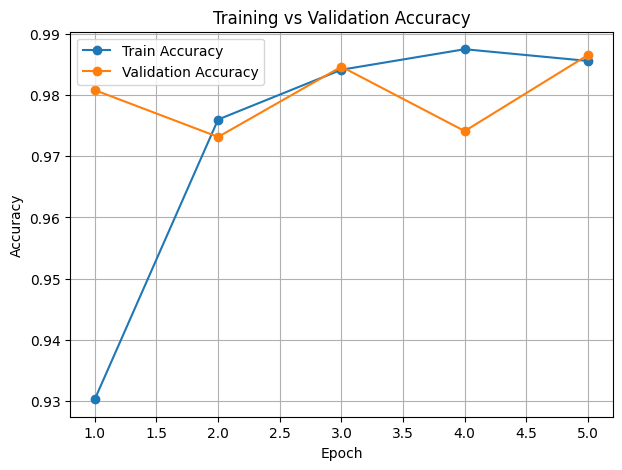


Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       268
   Pneumonia       1.00      0.98      0.99       776

    accuracy                           0.99      1044
   macro avg       0.98      0.99      0.98      1044
weighted avg       0.99      0.99      0.99      1044



In [6]:
print("\nGenerating Metrics...")
model.eval() # Keep model on GPU

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(val_dl, desc="Evaluating"):
        # Move inputs to GPU for fast inference
        inputs = inputs.to(device) 
        
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        # Move results back to CPU for numpy/plotting
        y_true.extend(labels.numpy()) # labels were loaded on CPU initially in val_dl
        y_pred.extend(preds.cpu().numpy())

# Plot Accuracy
plt.figure(figsize=(7,5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, marker='o', label="Train Accuracy")
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
unique_labels = np.unique(y_true)
class_map = {0: "Normal", 1: "Pneumonia"}
used_classes = [class_map[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=used_classes))

Evaluating model performance with PNEUMONIA THRESHOLD = 0.35


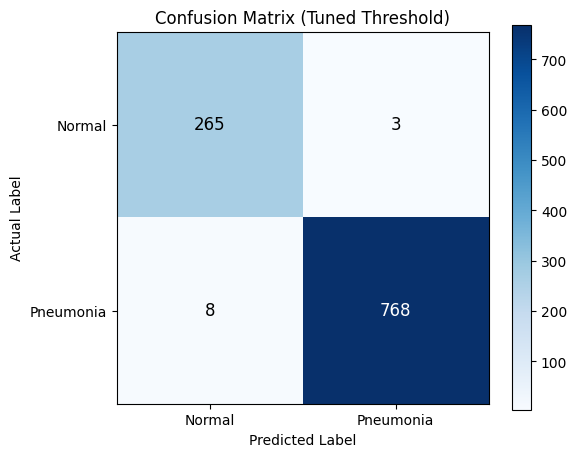


Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       268
   Pneumonia       1.00      0.99      0.99       776

    accuracy                           0.99      1044
   macro avg       0.98      0.99      0.99      1044
weighted avg       0.99      0.99      0.99      1044



In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
# --- Custom Thresholding ---
CUSTOM_THRESHOLD = 0.35 

# --- Evaluation ---
print(f"Evaluating model performance with PNEUMONIA THRESHOLD = {CUSTOM_THRESHOLD}")
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_dl, desc="Collecting Predictions"):
        inputs = inputs.to(device) 
        
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        
        y_true.extend(labels.numpy())
        y_probs.extend(probs.cpu().numpy())

y_probs = np.array(y_probs)

# Apply the custom threshold to the Pneumonia class (index 1)
y_pred_tuned = (y_probs[:, 1] >= CUSTOM_THRESHOLD).astype(int)

# --- Compute and Plot Confusion Matrix ---
unique_labels = np.unique(y_true)
class_map = {0: "Normal", 1: "Pneumonia"}
used_classes = [class_map[i] for i in unique_labels]

cm = confusion_matrix(y_true, y_pred_tuned, labels=unique_labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Tuned Threshold)")
plt.colorbar()

plt.xticks(range(len(used_classes)), used_classes)
plt.yticks(range(len(used_classes)), used_classes)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, cm[i, j], ha="center", va="center", color=color, fontsize=12)

plt.show() 

# --- Classification Report ---
print("\nClassification Report (Precision, Recall, F1-Score):")
print(classification_report(y_true, y_pred_tuned, target_names=used_classes))